In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pickle
from datetime import datetime

In [3]:
with open("/content/drive/MyDrive/Projeto CNI - Produções/13. Patentes/dw_df.pkl", 'rb') as file:
    dw_search = pickle.load(file)
    derwent_patents = dw_search["Patent Number"].str.split(";  ").explode().reset_index(drop=True)
    derwent_patents = derwent_patents.str.replace("-", "")

In [4]:
gp_search = pd.read_excel("/content/drive/MyDrive/Projeto CNI - Produções/Dados Energia/Sustainable Aviation Fuel - SAF/gp-search-SAF.xlsx", header=1)
gp_search.id = gp_search.id.str.replace("-", "")
gp_search.shape

(193, 10)

In [5]:
df_ipc_desc = pd.read_excel("/content/drive/MyDrive/Projeto CNI - Produções/Dados Energia/Sustainable Aviation Fuel - SAF/Dicionário IPC/IPC4_Desc.xlsx")
df_ipc_desc.Description = df_ipc_desc.Description.str.capitalize()
df_ipc_desc.rename(columns={"Description": "IPC4_Desc"}, inplace=True)

In [6]:
# Filtra patentes que estão no GP, mas não estão na DII.
#patentes = gp_search[~gp_search.id.isin(derwent_patents)]
#patentes.shape

In [7]:
#f"Há {len(patentes)} que estão no Google Patents e não estão no Derwent de um total de {len(gp_search)} patentes encontradas no GP."

In [8]:
# Excluindo as WO
patentes = gp_search[~gp_search.id.str.startswith("WO")]
patentes.shape

(126, 10)

In [9]:
# Função responsável por extrair as informações das patentes
def extrair_informacoes_patente(url):
    #url = f"https://patents.google.com/patent/{numero_patente}"

    # Fazendo a solicitação HTTP
    response = requests.get(url)

    # Verifica se a solicitação foi bem-sucedida
    if response.status_code == 200:
        # Parseando o conteúdo HTML
        soup = BeautifulSoup(response.content, 'html.parser')

        # Verifica se o título da patente existe
        titulo = ''
        titulo_element = soup.find('span', itemprop='title')
        if titulo_element:
            titulo = titulo_element.text.strip()

        patent_number = ''
        patent_number = soup.find('dd', itemprop="publicationNumber")
        if patent_number:
            patent_number = patent_number.text.strip()

        # Verifica se os inventores da patente existem
        inventores = []
        inventores_elements = soup.find_all('dd', itemprop='inventor')
        if inventores_elements:
            inventores = [inventor.text.strip() for inventor in inventores_elements]

        # Verifica se o resumo da patente existe
        resumo = ''
        resumo_element = soup.find('div', class_='abstract')
        if resumo_element:
            resumo = resumo_element.text.strip()

        # Verifica se a descrição da patente existe
        description = ''
        description_elements = soup.find_all('div', class_='description-paragraph')
        if description_elements:
            description = "\n".join([desc.text.strip() for desc in description_elements]).lower()

        # Verifica se a situação da patente existe
        status = ''
        status_element = soup.find('span', itemprop='status')
        if status_element:
            status = status_element.text.strip()

        # Verifica se a Filling Date da patente existe
        filingDate = ''
        filingDate_element = soup.find('time', itemprop='filingDate')
        if filingDate_element:
            filingDate = filingDate_element.text.strip()

        # Verifica se o responsável da patente existe
        assignee = ''
        assignee_element = soup.find('dd', itemprop='assigneeCurrent')
        if assignee_element:
            assignee = assignee_element.text.strip()
        else:
            assignee_element = soup.find('meta', scheme='assignee')["content"]
            if assignee_element:
              assignee = assignee_element.strip()

        family_size = ''
        family_size_trs = soup.find_all('tr', itemprop='priorityApps')
        if family_size_trs:
            family_size = len(family_size_trs)
        else:
            family_size_lis = soup.find_all('li', itemprop='application')
            if family_size_lis:
                  family_size = len(family_size_lis)

        # Verifica se a patente foi citada
        # Encontra todas as uls com itemprop="classifications"
        references = []
        forward_references_trs = soup.find_all('tr', itemprop='forwardReferencesOrig')
        references = len(forward_references_trs)
        # Itera sobre todas as trs encontradas
        #for tr in forward_references_trs:
            # Encontra todos os spans dentro da tr com itemprop="publicationNumber"
            #references_spans = tr.find_all('span', itemprop='publicationNumber')

            # Adiciona os números de publicação à lista references
            #if references_spans:
                #references += [span.text.strip() for span in references_spans]

        # Verifica se as classificações da patente
        # Encontra todas as uls com itemprop="classifications"
        classifications = []
        classifications_uls = soup.find_all('ul', itemprop='classifications')
        # Itera sobre todas as uls encontradas
        for ul in classifications_uls:
            # Encontra todos os spans dentro da ul com itemprop="Code"
            classification_span = ul.find_all('span', itemprop='Code')[-1]

            # Adiciona os números de publicação à lista classifications
            if classification_span:
                classifications += [span.text.strip() for span in classification_span]

        # Retornando um dicionário com as informações
        return {
            'Patent Number': patent_number,
            'Title': titulo,
            'Inventors': inventores,
            'Abstract': resumo,
            'Description': description,
            'Status': status,
            'Patent Assignee': assignee,
            'International Patent Classification': classifications,
            'Family Size': family_size,
            'Cited By': references,
            'Filing Date': filingDate
        }
    else:
        print(f"Patente {numero_patente}: não encontrada ou erro ao acessar a página")
        return None

In [10]:
# Lista para armazenar os dicionários de informações de patentes
lista_dicionarios = []

# Iterando sobre cada número de patente para extrair informações
for link_patente in patentes["result link"]:
    info_patente = extrair_informacoes_patente(link_patente)
    if info_patente:
        lista_dicionarios.append(info_patente)

# Criando o DataFrame
df_patentes = pd.DataFrame(lista_dicionarios)

qtd_total = len(patentes)
qtd_nao_encontrada = qtd_total - df_patentes.shape[0]
qtd_encontrada = qtd_total - qtd_nao_encontrada

print(f"{qtd_total} patentes pesquisadas no Google Patent.")
print(f"{qtd_encontrada} patentes encontradas na base.")
print(f"{qtd_nao_encontrada} patentes não foram encontradas na base.")

# Exibindo o DataFrame
df_patentes

126 patentes pesquisadas no Google Patent.
126 patentes encontradas na base.
0 patentes não foram encontradas na base.


,Patent Number,Title,Inventors,Abstract,Description,Status,Patent Assignee,International Patent Classification,Family Size,Cited By,Filing Date
0,US20230323821A1,Aircraft refuelling,"[Craig W Bemment, Benjamin J KEELER, Paul W Fe...",A method of refuelling an aircraft comprising ...,,Pending,Rolls Royce PLC,"[F02C9/40, F02C9/00, F02C9/28, F02C7/22, F05D2...",1,0,2023-03-23
1,US20230323822A1,Fuel delivery,"[Craig W Bemment, Benjamin J KEELER, Paul W Fe...",The present application discloses a method of ...,,Pending,Rolls Royce PLC,"[F02C9/28, F02C9/40, B64D37/00, B64D37/30, B64...",1,0,2023-03-23
2,EP4261138A1,Aircraft refuelling,"[Craig W Bemment, Benjamin J Keeler, Paul W Fe...",A method 2020 of refuelling an aircraft compri...,,Pending,Rolls Royce PLC,"[B64D37/005, B64D37/30, B64D27/10, F02C7/22]",4,0,2023-03-30
3,GB2616823A,Aircraft fuel management,"[Swann Peter, W Bemment Craig, G Hobday Alasta...",A method 2000 of identifying a fuel contained ...,aircraft fuel management\nthe present disclosu...,Pending,Rolls Royce PLC,"[F01D21/003, F02C9/40, F02C9/28, F23N5/00, G01...",5,0,2021-12-21
4,GB2614609A,Aircraft power system,"[Swann Peter, W Bemment Craig, G Hobday Alasta...",A power system 4 for an aircraft comprises one...,aircraft power system\nthe present disclosure ...,Granted,Rolls Royce PLC,"[B64D37/04, F02C9/40, B64D37/00, B64D37/02, B6...",3,1,2022-11-22
...,...,...,...,...,...,...,...,...,...,...,...
121,JP2023043883A,Filter medium for oil and fat and filtration m...,"[耕一郎 直原, Koichiro Naohara]",To provide a filter medium for oils and fats s...,,Pending,Individual,[],1,0,2022-09-15
122,US20230399572A1,Polyol treatment of hydrodeoxygenation feedstock,"[Martin Haverly, Ramin Abhari, David A. Slade]",The present invention relates to an improved p...,,Pending,Renewable Energy Group Inc,"[C10G3/50, C07C1/213, C07C67/03, C10G2400/02, ...",1,0,2023-06-09
123,FR3137109A1,Installation and process for producing hydroge...,"[Thibault DE SORBIER, Anne-Sophie VAN-INGHELAN...",,,Pending,Technip Energies France SAS,"[C25B1/04, C25B15/083, C25B9/70]",2,0,2022-06-27
124,CN117599797A,Ni-Bi bimetallic catalyst and application ther...,"[张浅, 匡敏军, 仇松柏, 吴小平, 王铁军]",The invention belongs to the technical field o...,technical field\nthe invention belongs to the ...,Pending,Guangdong University of Technology,"[B01J23/8437, B01J37/036, B01J37/086, C07C29/34]",1,0,2023-11-30


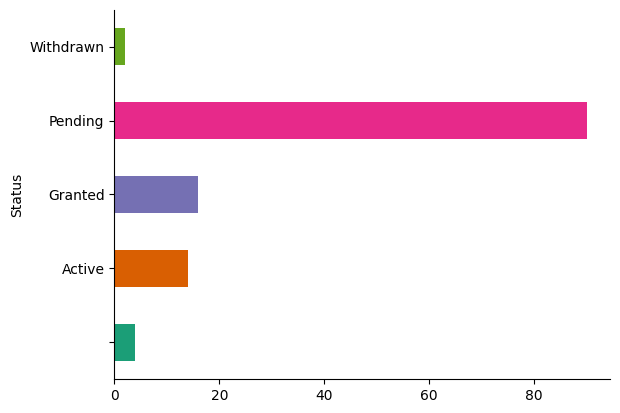

In [11]:
# @title Status

from matplotlib import pyplot as plt
import seaborn as sns
df_patentes.groupby('Status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [12]:
df_patentes_sem_ipc = df_patentes[df_patentes['International Patent Classification'].map(lambda x: len(x) == 0)]

print(f"{len(df_patentes_sem_ipc)} patentes sem classifição de IPC e serão removidas.")

df_patentes_sem_ipc

8 patentes sem classifição de IPC e serão removidas.


,Patent Number,Title,Inventors,Abstract,Description,Status,Patent Assignee,International Patent Classification,Family Size,Cited By,Filing Date
21,CN115688285A,Method for optimizing fuel supply and combusti...,"[徐征, 陈龙飞, 刘磊, 于振鸿, 李光泽, 钟生辉, 朱美印, 潘康]",The invention discloses a method for optimizin...,technical field\nthe invention relates to the ...,Pending,Hangzhou Innovation Research Institute of Beih...,[],1,2,2022-11-11
31,CN115730449A,High-altitude ventilation and spray combustion...,"[徐征, 陈龙飞, 于振鸿, 张斌, 潘康, 李光泽, 钟生辉, 梁志荣]",The invention discloses a sustainable aviation...,technical field\nthe invention relates to the ...,Pending,Hangzhou Innovation Research Institute of Beih...,[],1,0,2022-11-24
47,CN115595183B,Sustainable aviation fuel-based nanofluid fuel...,"[黄小彬, 盛浩强, 刘洪�]",A sustainable aviation fuel-based nano fluid f...,technical field\nthe invention relates to a te...,Active,Shanghai Jiaotong University,[],1,0,2022-10-12
77,JP2022151754A,Aviation fuel oil and base material for aviati...,"[武 大塚, Takeshi Otsuka, 直樹 橋本, Naoki Hashimoto]",To provide an aviation fuel oil having a low p...,,Pending,Cosmo Oil Co Ltd,[],1,0,2022-03-18
82,CN117396582A,"Method for decomposing organic raw material, a...","[松永兴哲, 越川哲也, 东裕一郎, 越川翔生, 持田勲]","A method for decomposing an organic material, ...",technical field\nthe present invention relates...,Pending,Revo International Inc,[],1,0,2022-04-12
103,CN220034424U,Biological aviation kerosene raw material pret...,"[徐兴, 陈凤飞, 叶彬, 叶小林]",The utility model discloses a pretreatment sys...,technical field\nthe utility model belongs to ...,Active,Sichuan Jindeyi Oil Co ltd,[],1,0,2023-04-21
104,CN220034423U,Circulating water storage tank for producing b...,"[徐兴, 陈凤飞, 叶彬, 叶小林]",The utility model discloses a circulating wate...,technical field\nthe utility model belongs to ...,Active,Sichuan Jindeyi Oil Co ltd,[],1,0,2023-04-21
121,JP2023043883A,Filter medium for oil and fat and filtration m...,"[耕一郎 直原, Koichiro Naohara]",To provide a filter medium for oils and fats s...,,Pending,Individual,[],1,0,2022-09-15


In [13]:
# Função para verificar se um valor está vazio ou é apenas espaços em branco
def is_empty(value):
    return pd.isna(value) or str(value).strip() == ''

df_patentes_sem_family = df_patentes[df_patentes['Family Size'].apply(is_empty)]

print(f"{len(df_patentes_sem_family)} patentes sem Family Size e serão removidas.")

df_patentes_sem_family

0 patentes sem Family Size e serão removidas.


,Patent Number,Title,Inventors,Abstract,Description,Status,Patent Assignee,International Patent Classification,Family Size,Cited By,Filing Date


In [14]:
# Function to set color based on condition
def set_color_univ(value):
    if value.__contains__("Univ"):
        return 'green'
    else:
        return 'blue'

df_patentes['circle_color'] = df_patentes['Patent Assignee'].apply(set_color_univ)

In [15]:
agora = datetime.now()
df_patentes["Patent Year"] = df_patentes["Filing Date"].str[:4].astype('int64')
df_patentes["Years until expiration"] = (df_patentes["Patent Year"] + 20) - agora.year

def get_patent_color(value):
    if value <= 5:
        return "rgba(0, 255, 0, 0.9)"  # Light green with 50% opacity
    elif value <= 10:
        return "rgba(144, 238, 144, 0.8)"  # Light green with 50% opacity
    elif value <= 15:
        return "rgba(240, 128, 128, 0.8)"  # Light coral with 50% opacity
    else:
        return "rgba(255, 0, 0, 0.5)"  # Red with 50% opacity

# Apply the function to create the fading red hexadecimal column
df_patentes["triangle_color"] = df_patentes["Years until expiration"].apply(get_patent_color)

In [16]:
df_exploded = df_patentes.explode("International Patent Classification")
df_exploded["International Patent Classification"] = df_exploded["International Patent Classification"].str[:4]

In [17]:
# Exclui registros onde o IPC não foi encontrado
df_exploded = df_exploded[df_exploded["International Patent Classification"].notna()]

In [18]:
# Join com a tabela de descrição dos IPCs
df_exploded = pd.merge(df_exploded, df_ipc_desc, left_on="International Patent Classification", right_on="IPC4", how="left")

In [19]:
gp_search = df_exploded[["Patent Number", "Title", "Patent Assignee", "circle_color", "triangle_color", "International Patent Classification", "IPC4_Desc", "Family Size"]]

In [20]:
#dw_gp_df = pd.concat([dw_search, gp_search], ignore_index=True)

In [21]:
with open("/content/drive/MyDrive/Projeto CNI - Produções/13. Patentes/gp_df.pkl", 'wb') as file:
    pickle.dump(gp_search, file)

In [23]:
csv_path = "/content/teste.csv"
df_patentes.to_csv(csv_path, index=False)


---

Utilizar para TGP2

In [ ]:
df_patentes["HEFA"] = df_patentes.Description.str.contains('|'.join(list(map(lambda x : x.lower(), ["HEFA", "Hydroprocessed Esters and Fatty Acids"]))))
df_patentes["AtJ"] = df_patentes.Description.str.contains('|'.join(list(map(lambda x : x.lower(), ["Alcohol-to-Jet", "AtJ"]))))
df_patentes["F-T"] = df_patentes.Description.str.contains('|'.join(list(map(lambda x : x.lower(), ["Fischer-Tropsch", "Gas-to-Jet"]))))
df_patentes["DSHC"] = df_patentes.Description.str.contains('|'.join(list(map(lambda x : x.lower(), ["Direct Sugars to Hydrocarbons", "DSHC", "Synthesised Iso-Paraffins", "SIP"]))))
df_patentes["PtL"] = df_patentes.Description.str.contains('|'.join(list(map(lambda x : x.lower(), ["CHJ", "Catalytic Hydrothermolysis", "Catalytic Hydrothermolysis Jet"]))))
df_patentes

,Patent Number,Title,Inventors,Abstract,Description,Status,Patent Assignee,International Patent Classification,Family Size,Cited By,Filing Date,circle_color,Patent Year,Years until expiration,triangle_color,HEFA,AtJ,F-T,DSHC,PtL
0,US20230323821A1,Aircraft refuelling,"[Craig W Bemment, Benjamin J KEELER, Paul W Fe...",A method of refuelling an aircraft comprising ...,,Pending,Rolls Royce PLC,"[F02C9/40, F02C9/00, F02C9/28, F02C7/22, F05D2...",1,0,2023-03-23,blue,2023,19,"rgba(255, 0, 0, 0.5)",False,False,False,False,False
1,US20230323822A1,Fuel delivery,"[Craig W Bemment, Benjamin J KEELER, Paul W Fe...",The present application discloses a method of ...,,Pending,Rolls Royce PLC,"[F02C9/28, F02C9/40, B64D37/00, B64D37/30, B64...",1,0,2023-03-23,blue,2023,19,"rgba(255, 0, 0, 0.5)",False,False,False,False,False
2,EP4261138A1,Aircraft refuelling,"[Craig W Bemment, Benjamin J Keeler, Paul W Fe...",A method 2020 of refuelling an aircraft compri...,,Pending,Rolls Royce PLC,"[B64D37/005, B64D37/30, B64D27/10, F02C7/22]",4,0,2023-03-30,blue,2023,19,"rgba(255, 0, 0, 0.5)",False,False,False,False,False
3,GB2616823A,Aircraft fuel management,"[Swann Peter, W Bemment Craig, G Hobday Alasta...",A method 2000 of identifying a fuel contained ...,aircraft fuel management\nthe present disclosu...,Pending,Rolls Royce PLC,"[F01D21/003, F02C9/40, F02C9/28, F23N5/00, G01...",5,0,2021-12-21,blue,2021,17,"rgba(255, 0, 0, 0.5)",False,False,False,False,False
4,GB2614609A,Aircraft power system,"[Swann Peter, W Bemment Craig, G Hobday Alasta...",A power system 4 for an aircraft comprises one...,aircraft power system\nthe present disclosure ...,Granted,Rolls Royce PLC,"[B64D37/04, F02C9/40, B64D37/00, B64D37/02, B6...",3,1,2022-11-22,blue,2022,18,"rgba(255, 0, 0, 0.5)",False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,JP2023043883A,Filter medium for oil and fat and filtration m...,"[耕一郎 直原, Koichiro Naohara]",To provide a filter medium for oils and fats s...,,Pending,Individual,[],1,0,2022-09-15,blue,2022,18,"rgba(255, 0, 0, 0.5)",False,False,False,False,False
122,US20230399572A1,Polyol treatment of hydrodeoxygenation feedstock,"[Martin Haverly, Ramin Abhari, David A. Slade]",The present invention relates to an improved p...,,Pending,Renewable Energy Group Inc,"[C10G3/50, C07C1/213, C07C67/03, C10G2400/02, ...",1,0,2023-06-09,blue,2023,19,"rgba(255, 0, 0, 0.5)",False,False,False,False,False
123,FR3137109A1,Installation and process for producing hydroge...,"[Thibault DE SORBIER, Anne-Sophie VAN-INGHELAN...",,,Pending,Technip Energies France SAS,"[C25B1/04, C25B15/083, C25B9/70]",2,0,2022-06-27,blue,2022,18,"rgba(255, 0, 0, 0.5)",False,False,False,False,False
124,CN117599797A,Ni-Bi bimetallic catalyst and application ther...,"[张浅, 匡敏军, 仇松柏, 吴小平, 王铁军]",The invention belongs to the technical field o...,technical field\nthe invention belongs to the ...,Pending,Guangdong University of Technology,"[B01J23/8437, B01J37/036, B01J37/086, C07C29/34]",1,0,2023-11-30,green,2023,19,"rgba(255, 0, 0, 0.5)",False,False,False,False,False


In [ ]:
# Trecho de código para baixar o HTML da patente gerada pelo BeautifulSoup para validações e teste
# Número da patente
numero_patente = "JP2023043883A"

# URL da patente
url = f"https://patents.google.com/patent/{numero_patente}/en"

# Fazendo a solicitação HTTP
response = requests.get(url)

# Verifica se a solicitação foi bem-sucedida
if response.status_code == 200:
    # Parseando o conteúdo HTML
    soup = BeautifulSoup(response.content, 'html.parser')

    # Convertendo para string
    conteudo = str(soup)

    # Abre um arquivo para escrita
    with open(f"{numero_patente}.html", "w") as arquivo:
        # Escreve o conteúdo no arquivo
        arquivo.write(conteudo)

# Imprime a URL da patente
print("URL da patente:", url)